In [96]:
import numpy as np
import sep
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astropy.io import fits

>f4


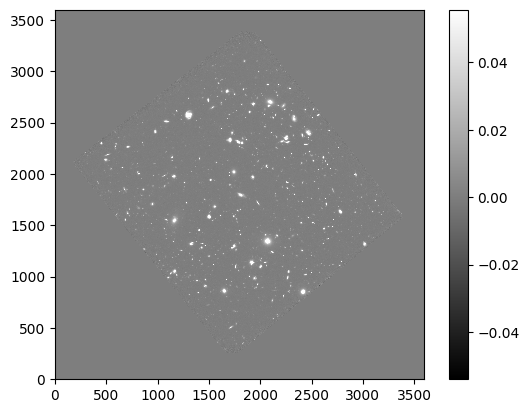

In [97]:
#with astropy read image
hdu = fits.open("hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = hdu[0].data

print(data.dtype)
#this is float32 in the tutorial one and the background measure doesn't work with what it is here (>f4)
#so I am changing it to float32
data = data.astype(data.dtype.newbyteorder('=float32'))

#set variables m and s for mean and standard deviation values of image data set
m, s = np.mean(data), np.std(data)

plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

plt.savefig('final_1.png', bbox_inches='tight')

In [98]:
#background subtraction

#measure background of image
bkg = sep.Background(data)

print(bkg.globalback)

0.0


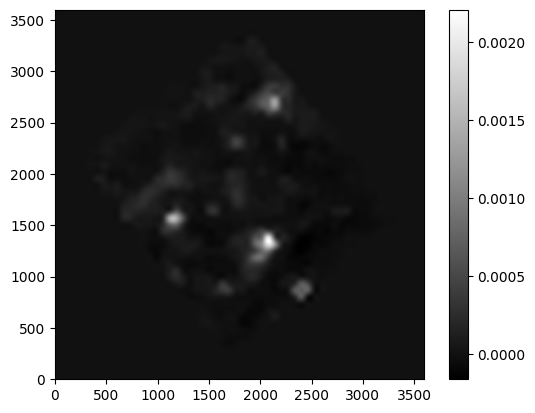

In [99]:
#background as array like above data set
bkg_image = bkg.back()

plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

plt.savefig('final_2.png', bbox_inches='tight')

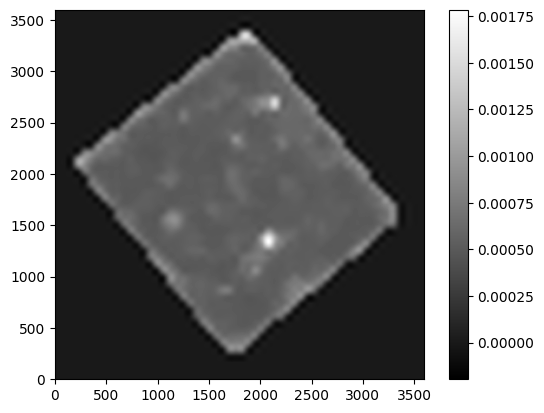

In [100]:
#background noise as array
bkg_rms = bkg.rms()

plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower') #same parameters as last time
plt.colorbar();

plt.savefig('final_3.png', bbox_inches='tight')

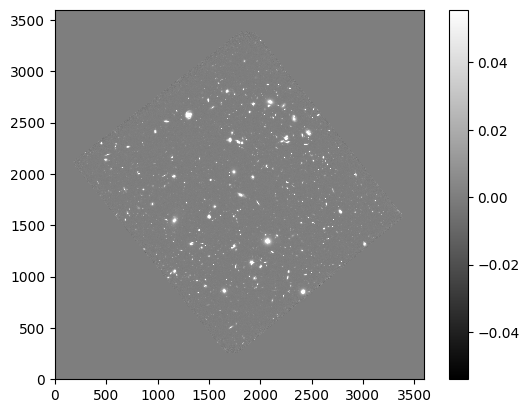

In [101]:
#subtract background from data
data_sub = data - bkg

plt.imshow(data_sub, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [102]:
print(bkg.globalrms)

0.0005398219218477607


In [103]:
#object detection

#detection threshold is a multiple of sigma, where sigma is background noise
#when I did this with the tutorial's detection threshold of 1.5sigma it detected 8640 objects, the vast majority of which
# were very close to zero flux
# which made for a histogram with nearly every data point in one bin

#Since this image's background noise value (the error we're using here) is several orders of magnitude less than the tutorial
# a detection threshold of only 1.5sigma detected a lot of sources we can't even see in the image

#I want to set the detection threshold in a way that detects mostly just what's visible in the image like in the tutorial
objects = sep.extract(data_sub, 10, err=bkg.globalrms)

# objects['x'] and objects['y'] will give coordinates of objects

#how many objects were detected
len(objects)

1545

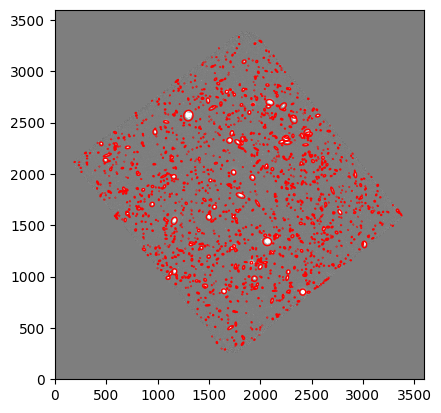

In [104]:
from matplotlib.patches import Ellipse

fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')


#plot ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)   #a, b, and theta also provided in objects
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)


plt.savefig('final_4.png', bbox_inches='tight')

In [105]:
#I think this detection threshold is good, it's catching every light source I could see in the image
# when the threshold was higher
#And it's not catching the really small fluxes that made up like 90% of the array when I used the tutorial's threshold

In [106]:
#circular aperture photometry with 3 pixel radius at obj locations

flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 1.150696 +/- 1.072709
object 1: flux = 0.132634 +/- 0.364200
object 2: flux = 0.108431 +/- 0.329301
object 3: flux = 0.552024 +/- 0.742989
object 4: flux = 1.123947 +/- 1.060168
object 5: flux = 0.870523 +/- 0.933023
object 6: flux = 0.289554 +/- 0.538110
object 7: flux = 0.153718 +/- 0.392079
object 8: flux = 0.126304 +/- 0.355404
object 9: flux = 0.696691 +/- 0.834685


In [107]:
print(flux)
print(len(flux))
print(min(flux))
print(max(flux))

[1.15069623 0.13263366 0.10843091 ... 0.26256645 0.96971648 0.26316952]
1545
0.03546508382637512
805.8583224487305


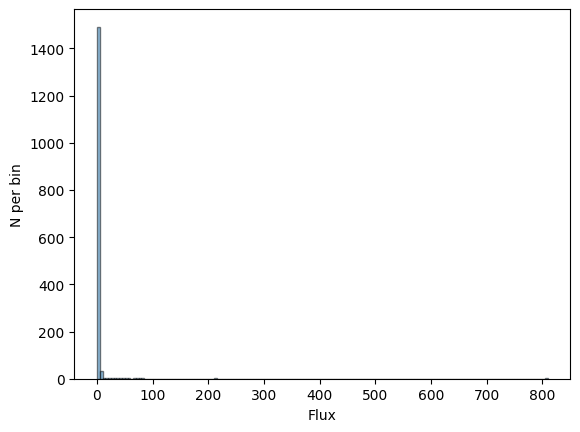

In [108]:
#making histogram

width = 5
histmin = np.floor(min(flux))
histmax = np.ceil(max(flux))+width

bins = np.arange(histmin, histmax, width)
plt.hist(flux,bins=bins,alpha=0.5,edgecolor="black")

plt.xlabel('Flux')
plt.ylabel('N per bin')

plt.savefig('final_hist', bbox_inches='tight')

In [109]:
#Still nearly all of the fluxes are very low. 
#Perhaps we could get a more readable histogram by making the threshold higher but at that point 
# it feels like I'm not counting all the light sources visible in the image

#I think its moreso just that this image has a whole lot of low-flux sources, which this histogram
# certainly does represent well

#This is readable anyway you can see the tiny bins at just over 200 and 800 flux

#the histogram that comes from using the 1.5 sigma threshold is uploaded to the github as final_hist_tutorial_sigma_value
#It's really not much different from this one

In [85]:
print(f"The median of the flux distribution is {np.median(flux)}.")
print(f"The mean of the flux distribution is {np.mean(flux)}.")
print(f"The standard deviation of the flux distribution is {np.std(flux)}.")

The median of the flux distribution is 0.31320176973007624.
The mean of the flux distribution is 1.8979036901375808.
The standard deviation of the flux distribution is 21.761801750809703.


In [86]:
# for i in range(1360):
        # print("object {:d}: x = {:f}: y = {:f}: flux = {:f}".format(i, objects['x'][i], objects['y'][i], flux[i]))

#Not running this again because it's really long and takes up too much space on here but here's what I found:

In [87]:
# object 269: x = 1914.190236: y = 1134.407320: flux = 805.858322
#The brightest object, the one with 805.8 flux, is located at x = 1914, y = 1134

#A flux of 805.858 is 36.943 standard deviations from the mean flux of 1.898
#If this were the stars/galaxies' luminosity a standard deviation this high would be effectively impossible,
# but since we're looking at flux (how much light we recieve) it's possible that one or two objects
# are many many times higher than the majority of the fluxes
# because we're getting much more light from objects that are closer to us
#like the sun is to the stars, much more light is recieved on earth despite other stars being comparable or higher
# in luminosity

In [88]:
#Hubble deep field

#define file names
#files are images at 3 different wavelength ranges
fdata_f105 = "hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
fdata_f125 = "hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
fdata_f160 = "hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

#read in data
hdu_2 = fits.open(fdata_f105) #105 is 2
hdu_3 = fits.open(fdata_f125) #125 is 3
hdu_4 = fits.open(fdata_f160) #160 is 4

#get the image data
data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

In [89]:
def rescale_image(data): #data is array that has image data in it
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin= m/2.0                 #depending on data set this /2 and *100 may not be ideal
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.0)
    pdata_tmp[pdata_tmp<vplmin] = vplmin    #floors data, cuts off low end cause we want to emphasize high
                                            #any data lower than 1/2 mean becomes the floor value cause we don't want to see noise
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax
    
    #returns copied array, min value, and max value
    #the rescale here is taking log of data and defining min and max

In [90]:
def fits_quicklook(data, fnx=10, fny=10):
    f = plt.figure(figsize=(fnx, fny))
    pdata_tmp,vpmin,vpmax = rescale_image(data)
    plt.imshow(pdata_tmp, vmin=vpmin, vmax=vpmax)

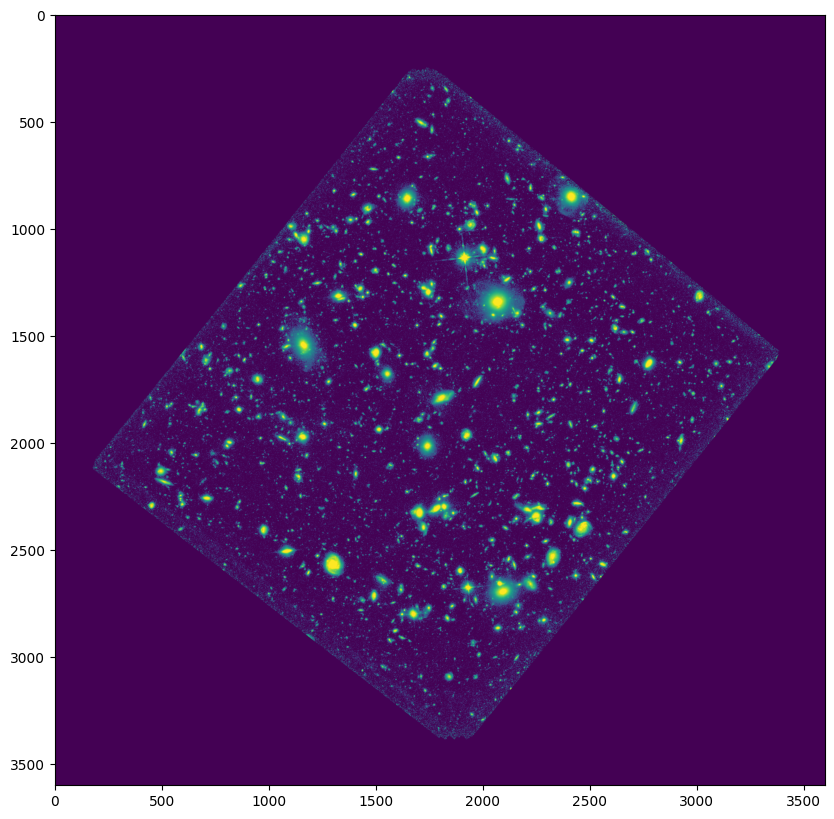

In [91]:
fits_quicklook(data_2)

In [92]:
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

In [93]:
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max

data_3_res[data_3_res<d2min] = d3min
data_3_res[data_3_res>d2max] = d3max

data_4_res[data_4_res<d2min] = d4min
data_4_res[data_4_res>d2max] = d4max

In [94]:
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1], 3))
#each wavelength band gets a color
rgb[:,:,0] = (data_4_res-d4min)/(d4max-d4min) #0 means red
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min) #1 means green
rgb[:,:,2] = (data_2_res-d2min)/(d2max-d2min) #2 means blue

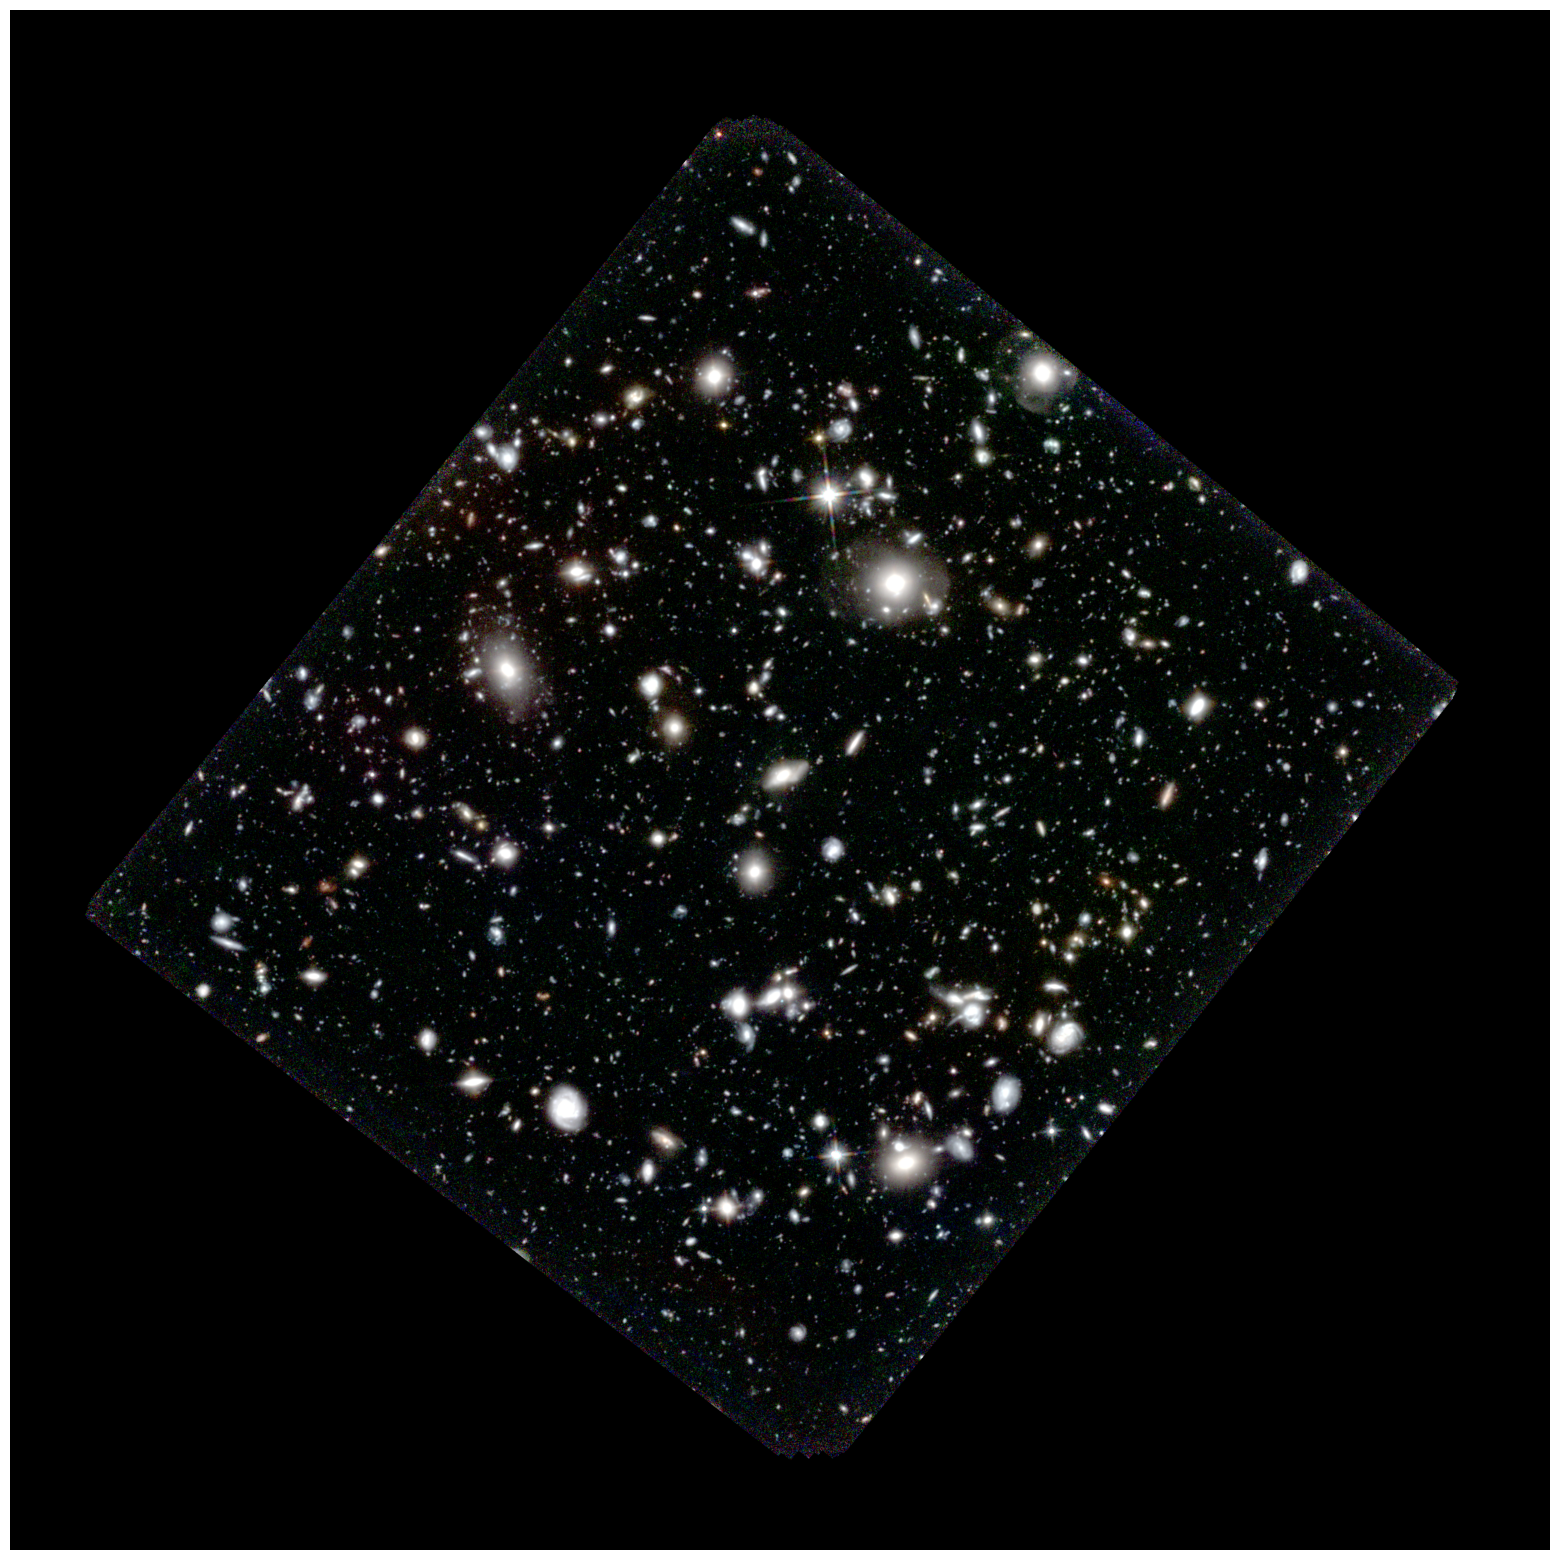

In [95]:
f, ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)

plt.savefig("HUDF", bbox_inches='tight')